In [252]:
import torch
from torch import embedding, nn
import torch.nn.functional as F
import torch.optim as optim
import random
import time
from tqdm import tqdm
from unet import UNet
from baseline import FaceRecognizer
from preprocessing import *
# train_data: tuple of length 320, each is a matrix represents a picture
# train_target: tuple of length 320, each is a label
# For training, there are 40 classes, each has 7 pictures
# For testing, there are 40 classes, each has 3 pictures

In [268]:
attack_targets = torch.tensor([[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]]) # the label of person to generate his image
faceRecognizer = FaceRecognizer()
faceRecognizer.load_state_dict(torch.load('best_model.pt'))
# init generator
generator = UNet(n_channels=1, n_classes=len(attack_targets))

# We use this as input of generator
# gan_input = (torch.sum(train_data, axis=0)+torch.sum(test_data, axis=0))/400 # avergae image


In [269]:
attack_targets.shape

torch.Size([10, 1])

In [270]:
def train_generator_1ep(generator, faceRecognizer, attack_targets, optimizer, criterion):  
    gan_input = torch.normal(0, 1, size=(1,1,64, 64)) # noise
    faceRecognizer.eval()
    generator.train()
    optimizer.zero_grad()
    generated_imgs = generator.forward(gan_input)
    loss = 0
    for i in range(attack_targets.shape[0]):
        z = faceRecognizer.forward(generated_imgs[0][i].reshape(1,1,64,64))
        loss+=criterion(z,attack_targets[i])
    loss.backward()
    optimizer.step()
    epoch_loss = loss.item()/len(attack_targets)

    return epoch_loss

In [292]:
def train_generator(eps, lr, reg, lr_decay):
    for epoch in range(eps): 
        optimizer = optim.SGD(generator.parameters(), lr=lr*lr_decay**epoch, momentum=0.9, weight_decay=reg, nesterov=False)
        criterion = nn.CrossEntropyLoss(reduction = 'sum')
        epoch_loss = 0
        epoch_loss += train_generator_1ep(generator, faceRecognizer, attack_targets, optimizer, criterion)
        print("loss(generator): ", epoch_loss)


In [298]:
train_generator(100, 0.001, 0.001, 0.99)

loss(generator):  0.007165399193763733
loss(generator):  0.009656576067209243
loss(generator):  0.00574973076581955
loss(generator):  0.008493182808160782
loss(generator):  0.007342436164617538
loss(generator):  0.007694600522518158
loss(generator):  0.008252706378698349
loss(generator):  0.006285062432289124
loss(generator):  0.008525922149419784
loss(generator):  0.006396100670099258
loss(generator):  0.008385749906301499
loss(generator):  0.008023152500391007
loss(generator):  0.006834007054567337
loss(generator):  0.010725168138742447
loss(generator):  0.006599949300289154
loss(generator):  0.0070820324122905735
loss(generator):  0.005211392417550087
loss(generator):  0.007002658396959305
loss(generator):  0.008840028196573257
loss(generator):  0.006927426159381867
loss(generator):  0.009049684554338456
loss(generator):  0.006786101311445236
loss(generator):  0.007627572864294052
loss(generator):  0.005860912799835205
loss(generator):  0.00706358477473259
loss(generator):  0.005555

In [299]:
def genrated_image(target):
    gan_input = torch.normal(0, 1, size=(1,1,64, 64)) # noise
    x = generator.forward(gan_input)
    tensor_to_picture(x[0][target].detach().numpy())

In [300]:
def genrated_confidence(target):
    gan_input = torch.normal(0, 1, size=(1,1,64, 64)) # noise
    x = generator.forward(gan_input)
    print(torch.softmax(faceRecognizer.forward(x[0][target].reshape(1,1,64,64)), -1))

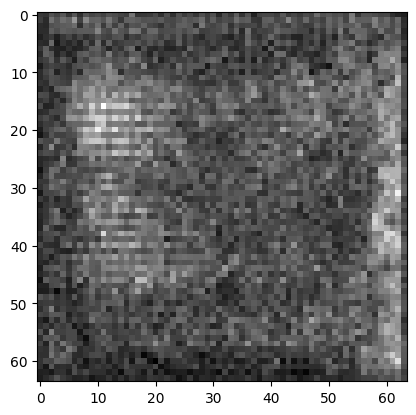

In [316]:
genrated_image(5)

In [320]:
genrated_confidence(5)

tensor([[7.3876e-04, 1.8565e-04, 1.3240e-04, 4.7107e-04, 8.4730e-04, 9.9032e-01,
         7.1898e-04, 5.4395e-04, 1.5695e-04, 1.5425e-04, 1.4938e-04, 8.0385e-05,
         3.0049e-04, 7.2670e-05, 7.0656e-05, 1.0360e-03, 2.9401e-04, 4.8216e-04,
         5.6301e-05, 9.2926e-05, 1.0756e-05, 4.8884e-05, 3.9461e-04, 2.5683e-05,
         3.2123e-04, 3.3926e-04, 7.1256e-05, 7.4684e-05, 2.7863e-05, 3.3396e-05,
         7.7929e-05, 4.9568e-04, 1.0631e-04, 6.1210e-05, 8.0737e-05, 3.1956e-04,
         5.7492e-05, 2.2956e-04, 3.3149e-05, 2.8367e-04]],
       grad_fn=<SoftmaxBackward>)


In [305]:
torch.save(generator.state_dict(), 'best_generator.pt')